In [17]:
from torch import optim
import os
import torchvision.utils as vutils
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models import inception_v3
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import entropy
from torchmetrics.image.fid import FrechetInceptionDistance

#from google.colab import drive

# Mount Google Drive
#drive.mount('/content/drive')

In [18]:
# Arguments
BATCH_SIZE = 64
Z_DIM = 100
LABEL_EMBED_SIZE = 5
NUM_CLASSES = 10
IMGS_TO_DISPLAY_PER_CLASS = 20
LOAD_MODEL = False

DB = 'SVHN'

CHANNELS = 3
EPOCHS = 25

# Define the directory where your images are
image_directory = 'TRAIN_AUG'

# # Define the directory where your images are in Google Drive
# image_directory = '/content/drive/My Drive/your_folder_name/TRAIN'

# Directories for storing data, model and output samples
model_path = os.path.join('./model', DB)
os.makedirs(model_path, exist_ok=True)
samples_path = os.path.join('./samples', DB)
os.makedirs(samples_path, exist_ok=True)

In [19]:
# Data loader

# Define the directory where your images are
image_directory = 'TRAIN_AUG'

transform = transforms.Compose([transforms.Resize([64, 64]),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])


train_dataset = datasets.ImageFolder(root=image_directory, transform=transform)

print(train_dataset)


data_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

print(data_loader)

#show labels of the dataset

print(train_dataset.classes)
print(len(train_dataset.classes))

Dataset ImageFolder
    Number of datapoints: 612
    Root location: TRAIN_AUG
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
['12', '13', '24', '38', '39', '44', '46', '49', '50', '6']
10


In [20]:
# Networks
def conv_block(c_in, c_out, k_size=4, stride=2, pad=1, use_bn=True, transpose=False):
    module = []
    if transpose:
        module.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    else:
        module.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    if use_bn:
        module.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*module)

In [21]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, num_classes=10, label_embed_size=5, channels=3, conv_dim=128):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, label_embed_size)
        self.tconv1 = conv_block(z_dim + label_embed_size, conv_dim * 8, pad=0, transpose=True)
        self.tconv2 = conv_block(conv_dim * 8, conv_dim * 4, transpose=True)
        self.tconv3 = conv_block(conv_dim * 4, conv_dim * 2, transpose=True)
        self.tconv4 = conv_block(conv_dim * 2, conv_dim, transpose=True)
        self.tconv5 = conv_block(conv_dim, channels, transpose=True, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, label):
        x = x.reshape([x.shape[0], -1, 1, 1])
        label_embed = self.label_embedding(label)
        label_embed = label_embed.reshape([label_embed.shape[0], -1, 1, 1])
        x = torch.cat((x, label_embed), dim=1)
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.relu(self.tconv3(x))
        x = F.tanh(self.tconv4(x))
        x = torch.tanh(self.tconv5(x))
        return x


In [22]:
class Discriminator(nn.Module):
    def __init__(self, num_classes=10, channels=3, conv_dim=128):
        super(Discriminator, self).__init__()
        self.image_size = 64
        self.label_embedding = nn.Embedding(num_classes, self.image_size*self.image_size)
        self.conv1 = conv_block(channels + 1, conv_dim, use_bn=False)
        self.conv2 = conv_block(conv_dim, conv_dim * 2)
        self.conv3 = conv_block(conv_dim * 2, conv_dim * 4)
        self.conv4 = conv_block(conv_dim * 4, conv_dim * 8)
        self.conv5 = conv_block(conv_dim * 8, 1, k_size=4, stride=1, pad=0, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, label):
        alpha = 0.2
        label_embed = self.label_embedding(label)
        label_embed = label_embed.reshape([label_embed.shape[0], 1, self.image_size, self.image_size])
        x = torch.cat((x, label_embed), dim=1)
        x = F.leaky_relu(self.conv1(x), alpha)
        x = F.leaky_relu(self.conv2(x), alpha)
        x = F.leaky_relu(self.conv3(x), alpha)
        x = F.leaky_relu(self.conv4(x), alpha)
        x = torch.sigmoid(self.conv5(x))
        return x.squeeze()

In [23]:
gen = Generator(z_dim=Z_DIM, num_classes=NUM_CLASSES, label_embed_size=LABEL_EMBED_SIZE, channels=CHANNELS)
dis = Discriminator(num_classes=NUM_CLASSES, channels=CHANNELS)


# Teste unitário para verificar a saída do gerador
test_noise = torch.randn(1, Z_DIM)
test_label = torch.LongTensor([1])  # Exemplo de label
gen_output = gen(test_noise, test_label)
print("Output shape from generator:", gen_output.shape)

# Teste unitário para o discriminador
dis_output = dis(gen_output, test_label)
print("Output from discriminator:", dis_output.shape)


Output shape from generator: torch.Size([1, 3, 64, 64])
Output from discriminator: torch.Size([])


In [24]:
gen = Generator(z_dim=Z_DIM, num_classes=NUM_CLASSES, label_embed_size=LABEL_EMBED_SIZE, channels=CHANNELS)
dis = Discriminator(num_classes=NUM_CLASSES, channels=CHANNELS)

# Load previous model   
if LOAD_MODEL:
    gen.load_state_dict(torch.load(os.path.join(model_path, 'gen.pkl')))
    dis.load_state_dict(torch.load(os.path.join(model_path, 'dis.pkl')))
    
# Model Summary
print("------------------Generator------------------")
print(gen)
print("------------------Discriminator------------------")
print(dis)

# Define Optimizers
g_opt = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
d_opt = optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)

# Loss functions
loss_fn = nn.BCELoss()

# Fix images for viz
fixed_z = torch.randn(IMGS_TO_DISPLAY_PER_CLASS*NUM_CLASSES, Z_DIM)
fixed_label = torch.arange(0, NUM_CLASSES)
fixed_label = torch.repeat_interleave(fixed_label, IMGS_TO_DISPLAY_PER_CLASS)


# GPU Compatibility
is_cuda = torch.cuda.is_available()
if is_cuda:
    gen, dis = gen.cuda(), dis.cuda()
    real_label, fake_label = real_label.cuda(), fake_label.cuda()
    fixed_z, fixed_label = fixed_z.cuda(), fixed_label.cuda()

total_iters = 0
max_iter = len(data_loader)

------------------Generator------------------
Generator(
  (label_embedding): Embedding(10, 5)
  (tconv1): Sequential(
    (0): ConvTranspose2d(105, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv5): Sequential(
    (0): ConvTranspose2d(128, 

In [25]:
# Training
for epoch in range(EPOCHS):
    gen.train()
    dis.train()

    for i, data in enumerate(data_loader):

        total_iters += 1

        x_real, x_label = data
        batch_size = x_real.size(0)  # Tamanho do batch atual

        # Ajustando o tamanho de z_fake para corresponder ao tamanho do batch atual
        z_fake = torch.randn(batch_size, Z_DIM)
        
        real_label = torch.full((batch_size,), 0.9, dtype=torch.float, device=device)
        fake_label = torch.full((batch_size,), 0.1, dtype=torch.float, device=device)

        if is_cuda:
            x_real = x_real.cuda()
            x_label = x_label.cuda()
            z_fake = z_fake.cuda()
                
        # Generate fake data
        x_fake = gen(z_fake, x_label)

        # Train Discriminator
        fake_out = dis(x_fake.detach(), x_label)
        real_out = dis(x_real.detach(), x_label)
        
        d_loss = (loss_fn(fake_out, fake_label) + loss_fn(real_out, real_label)) / 2

        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()

        # Train Generator
        fake_out = dis(x_fake, x_label)
        g_loss = loss_fn(fake_out, real_label)

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        if i % 50 == 0:
            print("Epoch: " + str(epoch + 1) + "/" + str(EPOCHS)
                  + "\titer: " + str(i) + "/" + str(max_iter)
                  + "\ttotal_iters: " + str(total_iters)
                  + "\td_loss:" + str(round(d_loss.item(), 4))
                  + "\tg_loss:" + str(round(g_loss.item(), 4))
                  )

        # generate_imgs(fixed_z, fixed_label, epoch=epoch + 1)

Epoch: 1/25	iter: 0/10	total_iters: 1	d_loss:1.3147	g_loss:19.1765
Epoch: 2/25	iter: 0/10	total_iters: 11	d_loss:1.4286	g_loss:17.0472
Epoch: 3/25	iter: 0/10	total_iters: 21	d_loss:0.9969	g_loss:10.3139
Epoch: 4/25	iter: 0/10	total_iters: 31	d_loss:2.0913	g_loss:21.7794
Epoch: 5/25	iter: 0/10	total_iters: 41	d_loss:0.9762	g_loss:20.8935
Epoch: 6/25	iter: 0/10	total_iters: 51	d_loss:0.7234	g_loss:2.4083
Epoch: 7/25	iter: 0/10	total_iters: 61	d_loss:1.0293	g_loss:5.3767
Epoch: 8/25	iter: 0/10	total_iters: 71	d_loss:0.5036	g_loss:4.6542
Epoch: 9/25	iter: 0/10	total_iters: 81	d_loss:0.6548	g_loss:6.4902
Epoch: 10/25	iter: 0/10	total_iters: 91	d_loss:0.6905	g_loss:5.6028
Epoch: 11/25	iter: 0/10	total_iters: 101	d_loss:0.4424	g_loss:3.6752
Epoch: 12/25	iter: 0/10	total_iters: 111	d_loss:0.4851	g_loss:2.7592
Epoch: 13/25	iter: 0/10	total_iters: 121	d_loss:0.7697	g_loss:4.4113
Epoch: 14/25	iter: 0/10	total_iters: 131	d_loss:0.6245	g_loss:3.8086
Epoch: 15/25	iter: 0/10	total_iters: 141	d_loss:0

In [26]:
# Função para calcular Inception Score
def inception_score(imgs, device, batch_size=32, resize=True, splits=10):
    N = len(imgs)
    
    # Inception v3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()
    
    def get_pred(x):
        if resize:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    preds = np.zeros((N, 1000))

    dataloader = DataLoader(TensorDataset(imgs), batch_size=batch_size)

    for i, batch in enumerate(dataloader, 0):
        batch = batch[0].to(device)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batch)

    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


## Metrics

In [27]:
# Gerar imagens usando o gerador treinado
def generate_images(generator, num_images, z_dim, num_classes, device):
    generator.eval()
    z = torch.randn(num_images, z_dim).to(device)
    labels = torch.randint(0, num_classes, (num_images,)).to(device)
    with torch.no_grad():
        images = generator(z, labels)
    return images

# Configurações
num_images = 100  # Número de imagens a serem geradas
z_dim = 100
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Gerar as imagens
images = generate_images(gen, num_images, z_dim, num_classes, device)

# Calcular o Inception Score
mean, std = inception_score(images, device)
print(f"Inception Score: {mean} ± {std}")

# Carregar imagens reais do DataLoader
real_images = []
for i, (data, _) in enumerate(data_loader):
    real_images.append(data)
    if len(real_images) * data.shape[0] >= num_images:
        break

real_images = torch.cat(real_images, dim=0)[:num_images] 

# Converta as imagens para uint8
real_images = (real_images * 255).byte()
generated_images = (images * 255).byte()

# Mover para o dispositivo (GPU/CPU)
real_images = real_images.to(device)
generated_images = generated_images.to(device)

# Preparar o objeto FID
fid = FrechetInceptionDistance(feature=2048).to(device)

# Calcular FID
fid.update(real_images, real=True)
fid.update(generated_images, real=False)

fid_score = fid.compute()
print(f'FID Score: {fid_score.item()}')

Inception Score: 1.7067752390931994 ± 0.22679971722772158
FID Score: 312.4044494628906


## Save the model for later use

In [28]:
torch.save(gen.state_dict(), os.path.join(model_path, 'gen.pkl'))
torch.save(dis.state_dict(), os.path.join(model_path, 'dis.pkl'))

In [29]:
def generate_imgs_for_all_labels(z, gen, num_labels, epoch=0):
    gen.eval()
    plt.figure(figsize=(15, 15))  # Ajusta o tamanho da figura para acomodar várias subfiguras

    for label in range(num_labels):
        fixed_label = torch.full((z.size(0),), label, dtype=torch.long)
        with torch.no_grad():
            fake_imgs = gen(z, fixed_label)
        fake_imgs = (fake_imgs + 1) / 2  # Normaliza as imagens para o intervalo [0, 1]
        fake_imgs_grid = vutils.make_grid(fake_imgs, normalize=False, nrow=IMGS_TO_DISPLAY_PER_CLASS)

        # Converter tensor de imagens para um formato que o matplotlib possa exibir
        np_img = fake_imgs_grid.permute(1, 2, 0).numpy()  # Reordenar as dimensões para HxWxC

        # Cria uma subfigura para cada label
        ax = plt.subplot(num_labels//2 + num_labels%2, 2, label + 1)  # Ajusta o layout da subplot
        ax.imshow(np_img)
        ax.set_title(f'Label {label}')
        ax.axis('off')  # Desativa os eixos

    plt.show()  # Mostra a imagem

In [30]:
def generate_img_for_label_after_training(z, label, gen_model, epoch=0):
    gen_model.eval()

    # Cria um tensor de labels com a label desejada
    fixed_label = torch.full((1,), label, dtype=torch.long)  # Mudança para gerar apenas uma imagem
    
    # Gera a imagem com a label específica
    with torch.no_grad():
        fake_img = gen_model(z[0:1], fixed_label)  # Seleciona apenas um z para geração
    fake_img = (fake_img + 1) / 2  # Normalização para adequar ao matplotlib
    
    # Converter tensor de imagens para um formato que o matplotlib possa exibir
    np_img = fake_img.squeeze(0).permute(1, 2, 0).numpy()  # Remove batch dim e reordena para HxWxC
    plt.figure(figsize=(1, 1))  # Define o tamanho da figura
    plt.imshow(np_img)
    plt.axis('off')  # Desativa os eixos
    plt.show()  # Mostra a imagem

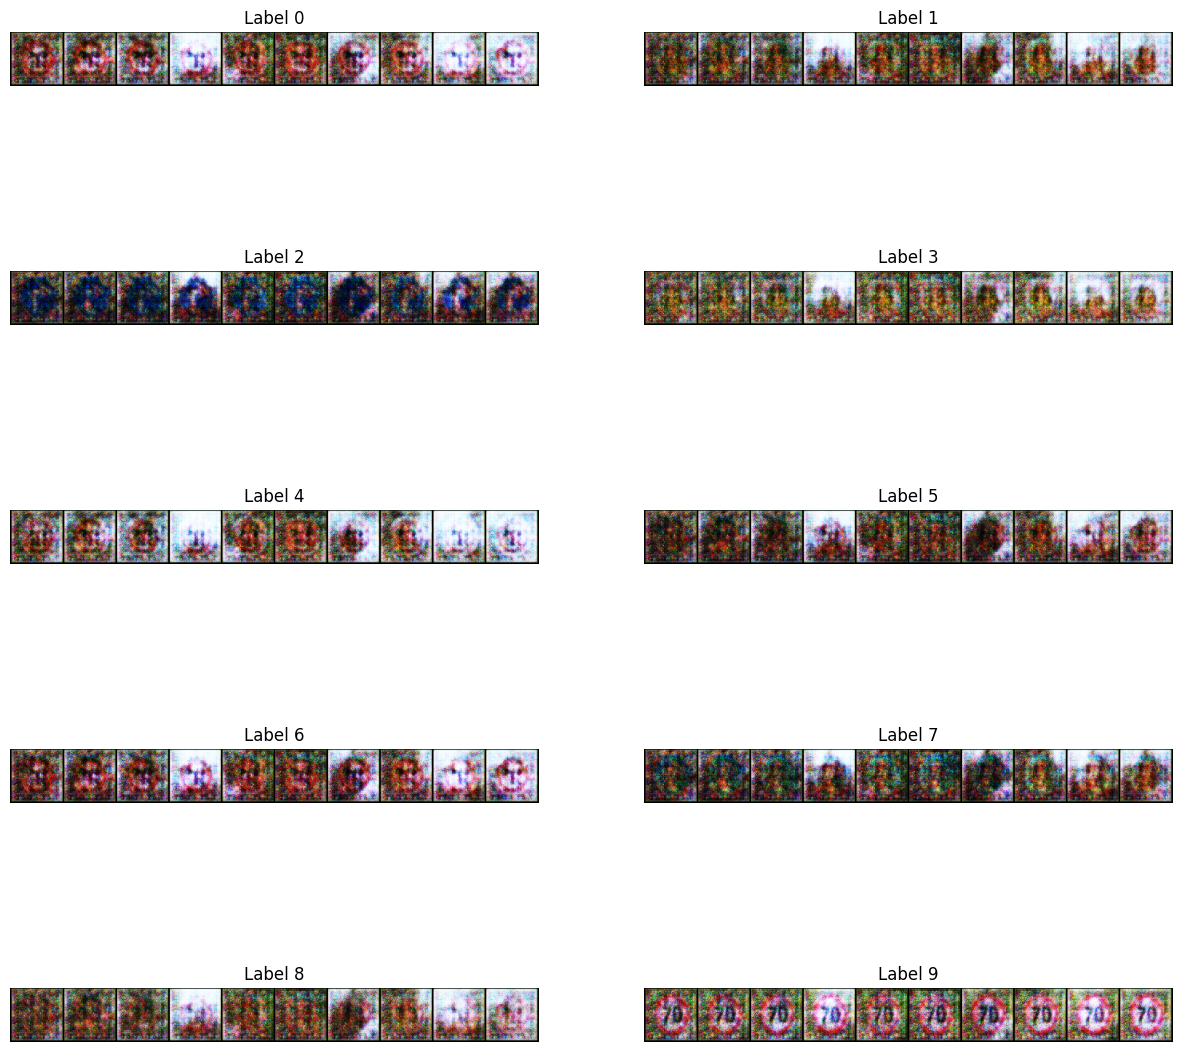

In [31]:
z = torch.randn(10, 100)

generate_imgs_for_all_labels(z, gen, 10)

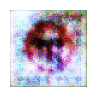

In [32]:
label_to_generate = 0
generate_img_for_label_after_training(fixed_z, label_to_generate, gen, epoch=epoch + 1)
